# In Session Memory

In [1]:
import operator 
from typing import Annotated, TypedDict, List
from langchain_ollama import ChatOllama 
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, START, END 
from langgraph.checkpoint.memory import InMemorySaver 
from IPython.display import Image, display
import os 
import time
from langsmith import Client
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, trim_messages

In [48]:
client = Client()
try:
    # This just pings the server to see if your API key is valid
    projects = list(client.list_projects())
    print("✅ LangSmith Connected! Found projects:", [p.name for p in projects])
except Exception as e:
    print("❌ LangSmith Connection Failed:", e)

llm = ChatOllama(model="llama3.2:1b")
print("Sending message...")
response = llm.invoke([HumanMessage(content="Hello LangSmith!")])
print("Response received.")
print("Waiting for trace to upload...")
time.sleep(3) 
print("Check your dashboard now!")

✅ LangSmith Connected! Found projects: []
Sending message...
Response received.
Waiting for trace to upload...
Check your dashboard now!


In [46]:
load_dotenv()
print(os.getenv("LANGSMITH_PROJECT"))
print(f"Tracing Enabled: {os.getenv('LANGSMITH_TRACING')}")

Simple-M2-Chatbot
Tracing Enabled: true


In [14]:
llm = ChatOllama(model = "llama3.2:1b", 
                 temperature=0.2,
                num_predict = 126)

search = DuckDuckGoSearchRun()

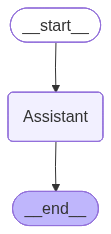

In [15]:
class ResearchState(TypedDict):
    content : str
    history : Annotated[list, operator.add]

def research_assistant(state: ResearchState):
    user_query = state["content"]
    chat_history = state.get("history", [])
    
    # SYSTEM PROMPT: Tell the LLM to use the history
    prompt = f"""
    You are a Research Assistant. 
    Review the previous research history: {chat_history}
    
    Current Task: {user_query}
    
    If you need new data from the web, start your response with 'SEARCH: [query]'.
    Otherwise, provide the comparison or answer directly.
    """
    
    response = llm.invoke(prompt).content
    
    if response.startswith("SEARCH:"):
        search_query = response.replace("SEARCH:", "").strip()
        raw_data = search.run(search_query)
        # Summarize the new data
        summary_prompt = f"Summarize this for the research session: {raw_data}"
        summary = llm.invoke(summary_prompt).content
        return {"content": summary, "history": [f"Task: {user_query}\nResult: {summary}"]}
    
    return {"content": response, "history": [f"Task: {user_query}\nResult: {response}"]}

# 4. Build and Compile with MemorySaver
builder = StateGraph(ResearchState)
builder.add_node("Assistant", research_assistant)
builder.add_edge(START, "Assistant")
builder.add_edge("Assistant", END)

# This is the key: InMemorySaver() instead of SQLite
memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [16]:
# Unique session ID
config = {"configurable": {"thread_id": "m2_research_session"}}

# TURN 1: Nvidia
print("--- TURN 1: Nvidia ---")
res1 = graph.invoke({"content": "Research Nvidia's latest earnings", "history": []}, config)
print(res1["content"])

# TURN 2: AMD (The agent will remember Nvidia here!)
print("\n--- TURN 2: Comparison ---")
res2 = graph.invoke({"content": "Now compare that with AMD's latest performance", "history": []}, config)
print(res2["content"])

--- TURN 1: Nvidia ---
I don't have any information about my previous research history. As a Research Assistant, I don't retain any information from previous tasks.

However, if you'd like me to search for Nvidia's latest earnings, here's what I found:

SEARCH: "Nvidia Q4 2023 earnings"

As of my knowledge cutoff in December 2023, Nvidia's quarterly earnings report for Q4 2023 was released on January 25, 2024. The company reported a strong fourth-quarter performance, with revenue growth and increasing margins.

Here are some key highlights from the report:

* Revenue: $23.8 billion

--- TURN 2: Comparison ---


Impersonate 'chrome_129' does not exist, using 'random'


Here's a summary of the research session on Advanced Micro Devices' (AMD) Q4 2023 earnings:

**Key Points**

* AMD announced revenue for Q4 2023 of $6.2 billion, up 10% year over year.
* Gross margin was 47%, operating income was $342 million, net income was $667 million, and diluted earnings per share was $0.41.
* The company's Data Center Business Unit (DCBU) had its best quarter ever in Q4, driven by strong performance of the server processor line, including EPYC 3rd Generation and EPYC 


# Chatbot

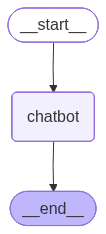

In [2]:
class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

llm = ChatOllama(model="llama3.2:1b", 
                 num_predict=256,
                 temperature=0.25)

def call_model(state: ChatState):
    # Just take the last 5 messages
    history = state["messages"][-5:] 
    
    # Fire the list directly to Ollama
    response = llm.invoke(history)
    
    # Return the response in a list so the Reducer can add it
    return {"messages": [response]}

# 4. BUILD THE GRAPH
builder = StateGraph(ChatState)
builder.add_node("chatbot", call_model)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# TOPIC: Short-term Memory
memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
config = {"configurable": {"thread_id": "m2_test"}}

# Turn 1
input_1 = {"messages": [HumanMessage(content="Hi, I'm testing my M2 chatbot!")]}
output_1 = graph.invoke(input_1, config)
print(f"Bot: {output_1['messages'][-1].content}")

# Turn 2
input_2 = {"messages": [HumanMessage(content="What is your opinion of NVIDIA ?")]}
output_2 = graph.invoke(input_2, config)
print(f"Bot: {output_2['messages'][-1].content}")

# Turn 3
input_3 = {"messages": [HumanMessage(content="Can you compare that with AMD ?")]}
output_3 = graph.invoke(input_3, config)
print(f"Bot: {output_3['messages'][-1].content}")

Bot: How can I assist you today?
Bot: As a neutral AI, I don't have personal opinions or biases towards any company. However, I can provide some general information about NVIDIA.

NVIDIA is a well-known American technology company that specializes in designing and manufacturing graphics processing units (GPUs) and high-performance computing hardware. The company was founded in 1993 by Jensen Huang, Chris Malachowsky, and Curtis Priem.

NVIDIA's GPUs are widely used in various fields, including:

1. Gaming: NVIDIA's GeForce series is a popular choice among gamers for its high-performance graphics capabilities.
2. Artificial intelligence (AI): NVIDIA's Tensor Core architecture is designed to accelerate AI workloads, making it an essential component in many AI applications.
3. Deep learning: NVIDIA's GPUs are used extensively in deep learning frameworks like TensorFlow and PyTorch, which are widely adopted in the machine learning community.

NVIDIA has also made significant investments in

In [30]:
output